In [48]:
import pandas as pd
import requests
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%%time

# Define the API endpoint and parameters
url = "https://data.cityofchicago.org/resource/cwig-ma7x.json"

# Fetch the total count of records
def get_total_count(url):
    params = {
        "$select": "count(*)"
    }
    response = requests.get(url, params=params)
    data = response.json()
    return int(data[0]['count'])

total_count = get_total_count(url)
print(f"Total number of records available: {total_count:,.0f}")

Total number of records available: 266,925
CPU times: total: 31.2 ms
Wall time: 242 ms


In [4]:
%%time

# Fetch data and load it into a pandas DataFrame
def fetch_data(url, params):
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data)

# Set the limit parameter equal to the number of available records
params = {
    "$limit": total_count
}

# Fetch the data and load it into a DataFrame
df = fetch_data(url, params)

print(f'Number of records retrieved: {df.shape[0]:,.0f}')

Number of records retrieved: 266,925
CPU times: total: 6.39 s
Wall time: 33.2 s


In [5]:
df.head(5)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,results,violations,latitude,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu
0,2588644,Evers,Evers,26591,School,Risk 1 (High),9811 S Lowe (632W),CHICAGO,IL,60628,...,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.71566429995683,-87.63926880772567,"{'type': 'Point', 'coordinates': [-87.63926880...",18,21861,72,593,22
1,2588643,THOMAS COFFEE SHOP,THOMAS COFFEE SHOP,7545,Restaurant,Risk 1 (High),1657 E 87TH ST,CHICAGO,IL,60617,...,Fail,35. APPROVED THAWING METHODS USED - Comments: ...,41.73684226984659,-87.5829466262428,"{'type': 'Point', 'coordinates': [-87.58294662...",9,21202,44,473,35
2,2588651,HUDSON NONSTOP,HUDSON (T3/K1),2951445,Grocery Store,Risk 3 (Low),10000 W OHARE ST,CHICAGO,IL,60666,...,Pass,NaN,41.97620113902387,-87.90530912510346,"{'type': 'Point', 'coordinates': [-87.90530912...",34,16197,75,668,29
3,2588636,"BETHEL NEW LIFE, INC.","BETHEL NEW LIFE, INC.",2204679,Long Term Care,Risk 1 (High),4950 W THOMAS ST,CHICAGO,IL,60651,...,No Entry,NaN,41.90058121225709,-87.75040561250974,"{'type': 'Point', 'coordinates': [-87.75040561...",4,4299,26,585,45
4,2588686,NY FISH AND CHICKEN,NY FISH AND CHICKEN,2695084,Restaurant,Risk 1 (High),2748-50 W MADISON ST,CHICAGO,IL,60612,...,Pass,NaN,41.88119123980771,-87.69580604798641,"{'type': 'Point', 'coordinates': [-87.69580604...",48,21184,28,38,46


## Preprocessing

In [6]:
clean_data = df.copy()
clean_data.dropna(subset = ['violations'], inplace=True)
def desc(x):
    pattern = r"\d+\. (.*?)(?: - Comments:|$)"
    parts = re.split(r'\|', x)
    res = []
    for part in parts:
        res = res + re.findall(pattern,part)
    return res

def comments(x):
    parts = re.split(r'\|',x)
    pattern = r'- Comments: (.*)'
    res = []
    for part in parts:
        res = res + re.findall(pattern,part)
    return res

clean_data["comments"] = clean_data.loc[:,"violations"].map(comments)

In [7]:
import nltk
import nltk.corpus  
from nltk.text import Text

# Ensure NLTK resources are downloaded (e.g., tokenizers, corpora)
nltk.download('punkt')

clean_data["comments_tokenized"] = clean_data["comments"].map(lambda x:[nltk.tokenize.word_tokenize(i) for i in x])



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\10124\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
nltk.download('stopwords')
from nltk.corpus import stopwords

def clean_tokens(tokens_list):
    cleaned_tokens_list = []
    # Assuming tokens_list is a list of lists
    for tokens in tokens_list:
        # Convert to lower case
        tokens = [token.lower() for token in tokens]
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        # Remove punctuation & numbers (keep only alphabetic tokens)
        tokens = [token for token in tokens if token.isalpha()]
        cleaned_tokens_list.append(tokens)
    return cleaned_tokens_list

# Assuming clean_data['comments_tokenized'] is a list of lists
clean_data['comments_tokenized_clean'] = clean_data['comments_tokenized'].apply(lambda x: clean_tokens(x) if isinstance(x, list) and all(isinstance(lst, list) for lst in x) else [])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\10124\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

wnl = WordNetLemmatizer()

def flatten_and_lemmatize(tokens_list_of_lists):
    # Flatten the list of lists into a single list
    flattened_list = [token for sublist in tokens_list_of_lists for token in sublist]
    # Lemmatize each token in the flattened list
    lemmatized_tokens = [wnl.lemmatize(token) for token in flattened_list]
    return lemmatized_tokens

# Apply the function to the column that contains a list of lists
clean_data['comments_tokenized_flatten_lemma'] = clean_data['comments_tokenized_clean'].apply(flatten_and_lemmatize)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\10124\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
clean_data['comments_final'] = clean_data['comments_tokenized_flatten_lemma'].apply(lambda x: ' '.join(map(str, x)))

In [12]:
clean_data.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,comments,comments_tokenized,comments_tokenized_clean,comments_tokenized_flatten_lemma,comments_final
0,2588644,Evers,Evers,26591,School,Risk 1 (High),9811 S Lowe (632W),CHICAGO,IL,60628,...,18,21861,72,593,22,[CERTIFIED MANAGER ON SITE HAS COPY OF CITY OF...,"[[CERTIFIED, MANAGER, ON, SITE, HAS, COPY, OF,...","[[certified, manager, site, copy, city, chicag...","[certified, manager, site, copy, city, chicago...",certified manager site copy city chicago sanit...
1,2588643,THOMAS COFFEE SHOP,THOMAS COFFEE SHOP,7545,Restaurant,Risk 1 (High),1657 E 87TH ST,CHICAGO,IL,60617,...,9,21202,44,473,35,[OBSERVED FROZEN MEAT IMRPOPERLY THAWING ON FL...,"[[OBSERVED, FROZEN, MEAT, IMRPOPERLY, THAWING,...","[[observed, frozen, meat, imrpoperly, thawing,...","[observed, frozen, meat, imrpoperly, thawing, ...",observed frozen meat imrpoperly thawing floor ...
5,2588700,"TONY'S TAMALES, LLC",TONY'S TAMALES,2873515,Restaurant,Risk 1 (High),5706 S WESTERN AVE,CHICAGO,IL,60636,...,19,22257,61,112,2,[OBSERVED NO SIGNED EMPLOYEES HEALTH POLICIES ...,"[[OBSERVED, NO, SIGNED, EMPLOYEES, HEALTH, POL...","[[observed, signed, employees, health, policie...","[observed, signed, employee, health, policy, m...",observed signed employee health policy must pr...
6,2588631,GOETHE ELEMENTARY SCHOOL,GOETHE ELEMENTARY SCHOOL,23341,School,Risk 1 (High),2236 N Rockwell,CHICAGO,IL,60647,...,24,22535,23,294,41,[PERSON IN CHARGE WITH NO CITY OF CHICAGO sANI...,"[[PERSON, IN, CHARGE, WITH, NO, CITY, OF, CHIC...","[[person, charge, city, chicago, sanitation, m...","[person, charge, city, chicago, sanitation, ma...",person charge city chicago sanitation manager ...
7,2588652,MONTESSORI OF ENGLEWOOD,MONTESSORI OF ENGLEWOOD,1362,School,Risk 1 (High),6936 S HERMITAGE AVE,CHICAGO,IL,60636,...,17,22257,65,283,31,[OBSERVED NO HAND WASHING SOAP AT ALL HAND SIN...,"[[OBSERVED, NO, HAND, WASHING, SOAP, AT, ALL, ...","[[observed, hand, washing, soap, hand, sinks, ...","[observed, hand, washing, soap, hand, sink, to...",observed hand washing soap hand sink toilet ro...


In [13]:
clean_data["results"].unique()

array(['Pass w/ Conditions', 'Fail', 'Pass', 'No Entry', 'Not Ready',
       'Out of Business'], dtype=object)

## Build a classification model
predicting the outcome of inspection – comments are predictors, target variable is “Results” column


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

In [15]:
violation = clean_data[["comments_final","results"]]

In [16]:
violation = violation[(violation["results"] == "Pass") | (violation["results"] == "Fail")]
violation.groupby("results").count()

,comments_final
results,
Fail,48679
Pass,104403


In [17]:
violation = violation.groupby("results").sample(n=10000, random_state=1)
violation.reset_index(inplace=True, drop=True)
violation.groupby("results").count()

,comments_final
results,
Fail,10000
Pass,10000


In [18]:
violation['result_flag'] = violation.results.map({'Fail':0, 'Pass':1})

In [19]:
X = violation.comments_final
y = violation.result_flag

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [21]:
# Initialize CountVectorizer with the desired ngram range
vect = CountVectorizer(ngram_range=(1, 2))

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [57]:
print(X_train)

18960    boy bathroom floor need detail cleaning remove...
11353    provide product dry food container floor tile ...
7449     observed slight debris accumulation encrusted ...
14308    must detail exhaust hood filter exhaust hood c...
11889    must properly label food storage container foo...
                               ...                        
10955    observed rusty shelving inside replace repair ...
17289    observed knife stored two cooler instructed pr...
5192     must post hand washing sign prep toilet room a...
12172    clean floor rear premise must provide exposed ...
235      observed water temperature hand sink rear prep...
Name: comments_final, Length: 15000, dtype: object


### Logistic Regression

In [88]:
logreg = LogisticRegression(max_iter=10000)

In [89]:
%time logreg.fit(X_train_dtm, y_train)

CPU times: total: 3.86 s
Wall time: 3.51 s


LogisticRegression(max_iter=10000)

In [90]:
y_pred_class = logreg.predict(X_test_dtm)

In [91]:
logic_accuracy = metrics.accuracy_score(y_test, y_pred_class)
print(f"Test Accuracy: {logic_accuracy * 100:.1f}%")

Test Accuracy: 97.2%


In [26]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2569
           1       0.96      0.99      0.97      2431

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



In [27]:
clf = logreg


feature_names = vect.get_feature_names_out()
coefs_with_fns = zip(feature_names, clf.coef_[0])

coefs_with_fns_df = pd.DataFrame(coefs_with_fns,
                    columns=['feature', 'coefficient'])

In [28]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=True, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
129131,serious,-3.629261
22183,citation,-2.132469
34920,critical,-2.103297
129302,serious violation,-1.872994
157873,violation,-1.691434
110304,priority,-1.620207
45490,dumpster,-1.519556
69304,hot running,-1.364313
35017,critical violation,-1.347528
44572,droppings,-1.311535


### Naive Bayes Model

In [101]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [102]:
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, y_train)

CPU times: total: 15.6 ms
Wall time: 15 ms


MultinomialNB()

In [103]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [104]:
# calculate accuracy of class predictions
bayes_accuracy = metrics.accuracy_score(y_test, y_pred_class)
print(f"Test Accuracy: {bayes_accuracy * 100:.1f}%")

Test Accuracy: 90.8%


In [33]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2569
           1       0.94      0.87      0.90      2431

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



In [80]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[2427  142]
 [  91 2340]]


In [36]:
clf = nb  # Assuming 'nb' is an instance of MultinomialNB that's already been fitted

feature_names = vect.get_feature_names_out()
log_prob = clf.feature_log_prob_

# Since we're dealing with log probabilities, you can directly use 'log_prob'
# Assuming interest in the first class for demonstration
coefs_with_fns = zip(feature_names, log_prob[0])

coefs_with_fns_df = pd.DataFrame(coefs_with_fns, columns=['feature', 'log_probability'])


In [37]:
coefs_with_fns_df.sort_values(by='log_probability', ascending=False, inplace=True)
coefs_with_fns_df.head(10)

,feature,log_probability
92284,must,-4.483265
56633,food,-4.484889
4547,area,-4.580358
73782,instructed,-4.626625
96567,observed,-4.704877
22667,clean,-4.831091
133444,sink,-4.932679
54563,floor,-5.042424
85551,maintain,-5.063515
108607,prep,-5.112472


### SVM

In [43]:
# instantiate a SVM model
svm = SGDClassifier(max_iter=100, tol=None)
# train the model using X_train_dtm
%time svm.fit(X_train_dtm, y_train)
# make class predictions for X_test_dtm
y_pred_class = svm.predict(X_test_dtm)

CPU times: total: 453 ms
Wall time: 450 ms


In [86]:
# calculate accuracy of class predictions
svm_accuracy = metrics.accuracy_score(y_test, y_pred_class)
print(svm_accuracy)

0.9534


In [39]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2569
           1       0.94      0.96      0.95      2431

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

[[2428  141]
 [  97 2334]]


In [40]:
svm

SGDClassifier(max_iter=100, tol=None)

In [41]:
clf = svm


feature_names = vect.get_feature_names_out()
coefs_with_fns = zip(feature_names, clf.coef_[0])

coefs_with_fns_df = pd.DataFrame(coefs_with_fns,
                    columns=['feature', 'coefficient'])

In [42]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=True, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
129131,serious,-4.490343
22183,citation,-3.717524
34920,critical,-2.998003
157873,violation,-2.871421
45490,dumpster,-2.804799
104229,pest control,-2.691541
73068,install,-2.644905
129302,serious violation,-2.458363
110304,priority,-2.451701
123247,rodent,-2.405065


### Explain why you selected a particular text pre-processing technique

1. Elimination of Stop Words: Commonly occurring words such as "and", "the", and "is" are often excluded from the analysis because they typically don't provide valuable insights for predictive models.

2. Exclusion of Numbers and Single Characters: In instances where not every unstructured comment is linked to a specific code (for example, "4-601.11(C):"), I ensure uniformity by discarding numbers and individual letters, thereby omitting code references from consideration.

3. Token Lemmatization: To achieve uniformity among tokens, I apply lemmatization, which adjusts tokens to their base forms, enhancing their comparability.

4. N-grams selection: after hyperparameter pipeline I find that ngram range of (1,2) works better. This may be because that using bigrams (pairs of consecutive words) along with unigrams allows the model to capture more context and the relationship between words, leading to a better understanding of the text's meaning. 

#### Build a pipeline with hyperparameter tuning to find out the best n-grams

In [73]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("clf", LogisticRegression()),
    ]
)
pipeline

Pipeline(steps=[('vect', CountVectorizer()), ('clf', LogisticRegression())])

In [77]:
parameter_grid = {
    'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
    'vect__min_df': (1, 3, 5, 10),
    'vect__ngram_range': ((1, 1), (1, 2)),  # Unigrams or bigrams
    'clf__C': np.logspace(-4, 4, 9),  # Inverse of regularization strength
    'clf__penalty': ['l1', 'l2'],  # Type of regularization
    # 'clf__solver': ['liblinear', 'saga'],  # Solver, might be required if using 'l1' penalty
}


In [78]:
from pprint import pprint

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=40,
    random_state=0,
    n_jobs=2,
    verbose=1,
)


print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'clf__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
 'clf__penalty': ['l1', 'l2'],
 'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vect__min_df': (1, 3, 5, 10),
 'vect__ngram_range': ((1, 1), (1, 2))}


In [79]:
from time import time

t0 = time()
random_search.fit(X_train, y_train)
print(f"Done in {time() - t0:.3f}s")

Fitting 5 folds for each of 40 candidates, totalling 200 fits


D:\python\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


115 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
115 fits failed with the following error:
Traceback (most recent call last):
  File "D:\python\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\python\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "D:\python\Lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\python\Lib\site-packages\sklearn\base.py", line 1152, in wrappe

Done in 125.745s


D:\python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [92]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__C: 1.0
clf__penalty: l2
vect__max_df: 0.4
vect__min_df: 1
vect__ngram_range: (1, 2)


In [93]:
test_accuracy = random_search.score(X_test, y_test)

print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.968
Accuracy on test set: 0.972


In [94]:
def shorten_param(param_name):
    """Remove components' prefixes in param_name."""
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = pd.DataFrame(random_search.cv_results_)
cv_results = cv_results.rename(shorten_param, axis=1)

In [95]:
import plotly.express as px

param_names = [shorten_param(name) for name in parameter_grid.keys()]
labels = {
    "mean_score_time": "CV Score time (s)",
    "mean_test_score": "CV score (accuracy)",
}
fig = px.scatter(
    cv_results,
    x="mean_score_time",
    y="mean_test_score",
    error_x="std_score_time",
    error_y="std_test_score",
    hover_data=param_names,
    labels=labels,
)
fig.update_layout(
    title={
        "text": "trade-off between scoring time and mean test score",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    }
)
fig

In [97]:
import math

column_results = param_names + ["mean_test_score", "mean_score_time"]

transform_funcs = dict.fromkeys(column_results, lambda x: x)

transform_funcs["ngram_range"] = lambda x: x[1]

fig = px.parallel_coordinates(
    cv_results[column_results].apply(transform_funcs),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis_r,
    labels=labels,
)
fig.update_layout(
    title={
        "text": "Parallel coordinates plot of text classifier pipeline",
        "y": 0.99,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    }
)
fig

### Visualize results of at least two text classifiers and select the most robust one
Logistic Regression Model is more robust.

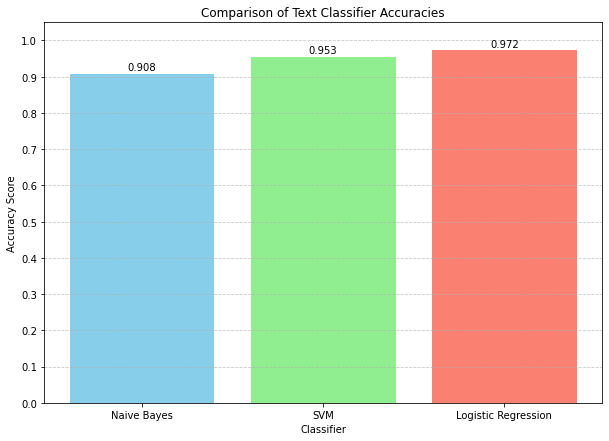

In [105]:
import matplotlib.pyplot as plt

# Classifier names
classifiers = ['Naive Bayes', 'SVM', 'Logistic Regression']

# Corresponding accuracy scores
accuracies = [bayes_accuracy, svm_accuracy, logic_accuracy]

# Creating the enhanced bar plot
plt.figure(figsize=(10, 7))
bars = plt.bar(classifiers, accuracies, color=['skyblue', 'lightgreen', 'salmon'])

# Adding data labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 3), ha='center', va='bottom')

plt.xlabel('Classifier')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Text Classifier Accuracies')
plt.ylim(0, 1.05)  # Extend y-axis limit slightly above 1 for better visibility of data labels
plt.yticks([i/10 for i in range(11)])  # Setting y-axis ticks to improve readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding horizontal gridlines for easier comparison
plt.show()
